In [27]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

## Importar datos

In [28]:
# Cargar datos desde el excel
df_r = pd.read_excel("Plantilla - Laboratorio 2.xlsx", sheet_name="Punto1_Rutas")
df_c = pd.read_excel("Plantilla - Laboratorio 2.xlsx", sheet_name="Punto1_Ciudades")

In [29]:
print(df_r.shape)
print(df_c.shape)

(50, 9)
(14, 3)


### Dataframe de infomracion de rutas

In [30]:
df_r.head()

,Origen,Destino,Transporte,Clima,Ventana_Horaria,Capacidad_Maxima_kg,Distancia_km,Refrigeracion,Tiempo_estimado_h
0,Medellín,Córdoba,Camión,Inestable,2-13,80,245,Sí,15.32
1,Santa Cruz,Medellín,Camión,Inestable,10-16,86,884,Sí,17.68
2,Guayaquil,Bogotá,Barco,Estable,4-17,86,756,Sí,30.24
3,Buenos Aires,La Paz,Camión,Estable,9-23,91,235,Sí,4.70
4,Arequipa,Quito,Barco,Tormenta,4-21,94,699,Sí,27.96


### Dataframe de ciudades

In [31]:
df_c.head()

,Nombre,Tipo_Transporte,Autonomia
0,Bogotá,fluvial,Media
1,Quito,terrestre,Media
2,Medellín,fluvial,Media
3,Lima,fluvial,Baja
4,Córdoba,terrestre,Media


## Crear grafo dirigido para las rutas disponibles

In [32]:
def crear_grafo_dirigido(df_r):
    G = nx.DiGraph()
    for _, row in df_r.iterrows():
        origen = row['Origen']
        destino = row['Destino']
        distancia = row['Distancia_km']
        tipo_transporte = row['Transporte']
        
        if tipo_transporte == 'Camión':
            constante = 1
        elif tipo_transporte == 'Barco':
            constante = 0.5
        elif tipo_transporte == 'Avión':
            constante = 2
        
        costo = 10 * distancia + 100 * constante
        
        G.add_edge(origen, destino, costo=costo)
    return G

# Crear el grafo dirigido
G = crear_grafo_dirigido(df_r)

## Visualizar el grafo

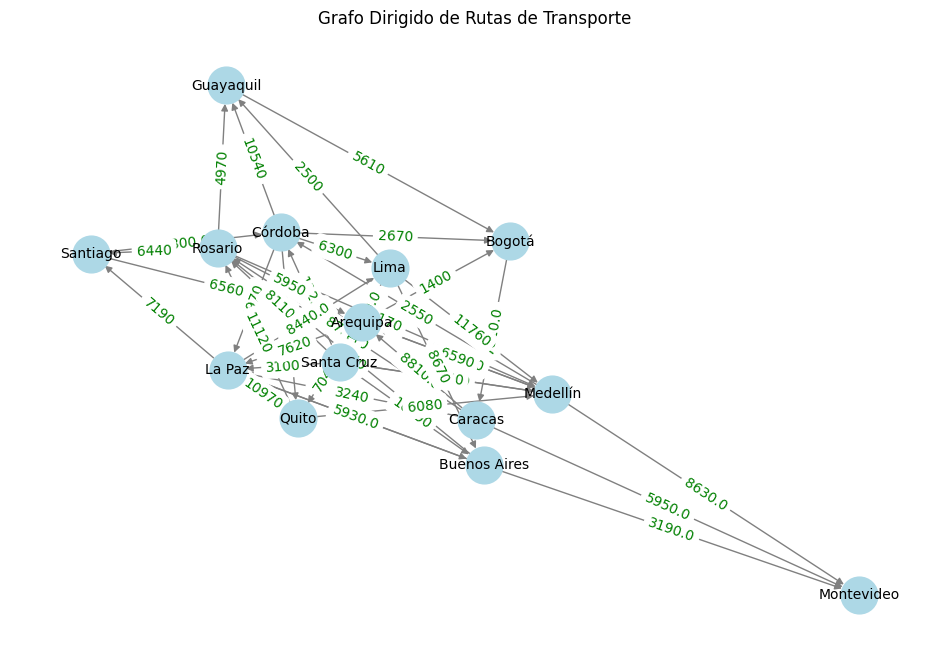

In [33]:
plt.figure(figsize=(12, 8), facecolor="white")
pos = nx.spring_layout(G)
nx.draw_networkx(
    G,
    pos,
    with_labels=True,
    node_color="lightblue",
    edge_color="gray",
    node_size=700,
    font_size=10,
)

# Mostrar los costos en las aristas
edge_labels = nx.get_edge_attributes(G, "costo")
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_color="green")

plt.title("Grafo Dirigido de Rutas de Transporte")
plt.axis("off")
plt.show()

## 1.2 El Centro de Distribución de Bogotá debe enviar urgentemente cinco cajas de vacunas al Hospital Regional de Quito, debido a un brote epidémico en dicha ciudad. Por requerimientos sanitarios, el envío debe pasar obligatoriamente por la estación de Medellín para validación de cadena de frío y documentación.

### Restricciones:

Una ruta solo se considera válida dentro del sistema si cumple todas las siguientes cinco condiciones ￼:

***

Condiciones de validez de una ruta
- Clima:
	La ruta no puede utilizarse si el clima es “Tormenta”, sin importar el tipo de transporte.
- Ventana horaria:
	Si la ventana horaria activa es menor a 8 horas disponibles, la ruta se considera no operativa y debe descartarse.

- Refrigeración:
	El transporte de vacunas solo puede realizarse en rutas con refrigeración disponible (“Sí”).

- Autonomía baja:
	El trayecto completo no puede incluir más de una estación con autonomía baja, ya que estas no garantizan condiciones de transferencia seguras.

- Capacidad máxima:
	Si el envío excede la capacidad máxima del tramo, se aplica una penalización del 15 % adicional al costo de esa ruta.

***

In [ ]:
# 🧮 Parámetros globales
contador_baja = 0
carga = 5 * 20  # 5 cajas de 20 kg

autonomia = {}

# 🗺️ Diccionario ciudad → autonomía (desde df_c)
for _, row in df_c.iterrows():
    ciudad = row['Nombre']
    autonomia[ciudad] = row['Autonomia']

def crear_grafo_dirigido_modificado(df_r):
    """
    Construye el grafo dirigido G con las siguientes condiciones:

    - ❌ Filtros por tramo:
        1. Clima distinto de 'Tormenta'
        2. Ventana horaria ≥ 8 horas
        3. Refrigeración disponible = 'Si'

    - 💰 Costo por tramo:
        10 * distancia + 100 * factor_transporte

    - ⚠️ Penalización:
        +15% si la carga excede la capacidad máxima del tramo.

    - 🧩 Atributo de nodo:
        'autonomia' = {'Alta', 'Media', 'Baja'}
    """
    
    G = nx.DiGraph()
    
    # * ----------------------------------------------------------
    # * Recorrer las rutas (filas del DataFrame)
    # * ----------------------------------------------------------
    
    for _, row in df_r.iterrows():
        
        # * ------------------------------------------------------
        # * Lectura de variables de entrada
        # * ------------------------------------------------------
        
        origen = row['Origen']
        destino = row['Destino']
        tipo_transporte = row['Transporte']
        clima = row['Clima']
        ventana_horaria = row['Ventana_Horaria']
        capacidad = float(row['Capacidad_Maxima_kg'])
        distancia = float(row['Distancia_km'])
        refrigeracion = row['Refrigeracion']
        tiempo_estimado_horas = float(row['Tiempo_estimado_h'])
        
        # * ------------------------------------------------------
        # * Aplicar filtros de viabilidad del tramo
        # * ------------------------------------------------------
        
        
        # * Filtro 1 - La ruta no puede utilizarse si el clima es "Tormenta", sin importar el tipo de transporte.
        
        if clima == 'Tormenta':
            continue
        
        # * Filtro 2 - Si la ventana horario activa es menor a 8 horas disponibles, la ruta se considera no operable.
        # Las ventanas horarias vienen en el formato "numero1-numero2", por ejemplo "8-20"
        
        inicio_ventana, fin_ventana = map(int, ventana_horaria.split('-'))
        
        if fin_ventana - inicio_ventana < 8:
            continue
        
        # * Filtro 3 - El transporte de vacunas solo puede realizarse en rutas con refrigeración disponible ("Si")
        
        if refrigeracion == 'No':
            continue
    
        # * Penalizacion por capacidad - Si el envío excede la capacidad máxima del tramo, se aplica una penalización del 15 % adicional al costo de esa ruta.
        
        if carga > capacidad:
            penalizacion = 0.15
        else:
            penalizacion = 0
            
        # * ------------------------------------------------------
        # * Calcular costo del tramo
        # * ------------------------------------------------------     
           
        costo = (10 * distancia + 100 * (1 if tipo_transporte == 'Camión' else 1.5 if tipo_transporte == 'Barco' else 2)) * (1 + penalizacion)

        # * ------------------------------------------------------
        # * Agregar arista válida al grafo
        # * ------------------------------------------------------
        
        G.add_edge(
            origen, 
            destino,
            costo=costo,
            distancia=distancia,
            tiempo=tiempo_estimado_horas,
            transporte=tipo_transporte,
            capacidad=capacidad,
            ventana=ventana_horaria,
            clima=clima,
            refrigeracion=refrigeracion
        )
        
    # * ----------------------------------------------------------
    # * Agregar atributo de autonomía a cada nodo
    # * ----------------------------------------------------------
    
    for node in G.nodes():
        G.nodes[node]['autonomia'] = autonomia.get(node, "Media")

    return G


## Dijkstra con restriccion de pasar por Medellin y una sola ciudad con autonomia baja

In [ ]:
import heapq

def dijkstra_modificado(G, source, target, ciudad_obligatoria):
    
    def es_baja(ciudad):
        return G.nodes[ciudad]['autonomia'] == "Baja"
    
    # * ===== Inicialización =====
    visite_medellin_0 = 1 if source == "Medellin" else 0
    bajas_0 = 1 if es_baja(source) else 0
    
    # * ===== Estructuras de datos =====
    heap = [(0, 0, source, visite_medellin_0, bajas_0, [source])]
    
    # * Diccionario para rastrear nodos
    visitados = dict()
    
    while heap:
        
        # * ======== Extracción del nodo con menor costo acumulado ========
        costo_acumulado, tiempo_acumulado, nodo, visite_medellin, bajas, ruta = heapq.heappop(heap)
        

        clave = (nodo, visite_medellin, bajas)
        
        # * ======== Principio de optimalidad: Si ya visite este nodo con la misma cantidad de visitas a Medellín y bajas, no lo vuelvo a visitar ========
        
        if clave in visitados and visitados[clave] <= (costo_acumulado, tiempo_acumulado):
            continue
        
        visitados[clave] = (costo_acumulado, tiempo_acumulado)
        
        # * ======== Criterio de llegada ========
        
        if nodo == target and visite_medellin == 1 and bajas <= 1:
            distancia = sum(G[ruta[i]][ruta[i+1]]['distancia'] for i in range(len(ruta)-1))
            
            return ruta, costo_acumulado, tiempo_acumulado, distancia
        
        # * ======= Expansión de nodos =======
        for vecino in G.neighbors(nodo):
            
            # ! Evitar ciclos
            if vecino in ruta:
                continue
            
            # Obtener datos de la arista
            arista = G.get_edge_data(nodo, vecino)
            
            # * ========================
            # * Calcular nuevos valores del heap
            # * ========================
            
            # Nuevos costos acumulados
            costo_acumulado_nuevo = costo_acumulado+arista["costo"]
            
            # Nuevo tiempo acumulado
            tiempo_acumulado_nuevo = tiempo_acumulado + arista["tiempo"]
            
            # Nuevo nodo
            nodo_nuevo = vecino
            
            # Nuevo conteo de bajas
            baja_nuevo = bajas + (1 if es_baja(vecino) else 0 )
            
            if baja_nuevo > 1:
                continue
            
            # Nueva visita a Medellín
            visite_medellin_nuevo = visite_medellin or (vecino==ciudad_obligatoria)
            
            # Empujar nuevo estado al heap
            heapq.heappush(heap, (costo_acumulado_nuevo, tiempo_acumulado_nuevo, nodo_nuevo, visite_medellin_nuevo, baja_nuevo, ruta + [vecino]))
            
    # Si no hay solucion valida
    
    return None, float("inf"), float("inf"), float("inf")    

In [36]:
G = crear_grafo_dirigido_modificado(df_r)
ruta, costo, tiempo, distancia = dijkstra_modificado(G, "Bogotá", "Quito", "Medellín")
if ruta is None:
    print("No existe ruta que cumpla pasar por Medellín y ≤1 ciudad 'Baja'.")
else:
    print("Ruta:", " → ".join(ruta))
    print(f"Costo: ${costo:,.2f} | Distancia: {distancia:.1f} km | Tiempo de viaje: {tiempo:.2f} h")

Ruta: Bogotá → Caracas → Arequipa → Medellín → Córdoba → Quito
Costo: $33,809.00 | Distancia: 3129.0 km | Tiempo de viaje: 83.96 h
